$\renewcommand{\a}{\alpha}$
$\renewcommand{\b}{\beta}$
$\renewcommand{\c}{\gamma}$
$\renewcommand{\d}{\delta}$
$\newcommand{\la}{\lambda}$
$\newcommand{\e}{\varepsilon}$
$\renewcommand{\t}{\tau}$
$\renewcommand{\th}{\theta}$
$\newcommand{\s}{\sigma}$
$\newcommand{\x}{\bar x}$
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\sign}{sign}$

## **Robust regression --- Mirror descent** 

If you have any questions you can additionally look at [this link](https://web.stanford.edu/class/cs229t/2017/Lectures/mirror-descent.pdf).

*Regression*: we have a sequence of vectors $a_i\in \R^d$ and measurements $b_i\in \R$ for $i=1,\dots, m$. 
We want to predict $b_i$ using $\lr{a_i, x}$ for some unknown $x\in \R^n$. 

Because of possible outliers (or other reasons) $\ell_2$-regression may be not a good choice, we want a more robust approach. 

Given $A\in \R^{m\times d}$ and $b\in \R^m$, minimize
$$ f(x) = \frac{1}{m} \lVert Ax-b\rVert_1  = \frac{1}{m}\sum_{i=1}^m |\lr{a_i,x} - b_i|$$


First, answer the following questions:

 - Is the problem convex? **Yes, $\ell_1$-norm is convex.**
 - Is the problem smooth / constrained? **Neither smooth nor constrained.**
 - What are the dimensions? **$x \in \mathbb{R}^d$, so $d$ dimensions.**
 


#### **Computing the subgradient**
 What is the subgradient of $f$ at $x$? For $y\mapsto \n{y}_1$ it is $\sign(y)$ (at zero any value from $[-1,1]$ will work). Thus,
 $$g(x) = \frac{1}{m} A^\top \sign(Ax-b) = \frac{1}{m} \sum_{i=1}^m a_i \sign(\lr{a_i,x} -b_i)$$
 
#### **Computing the stochastic subgradient**
 What is the stochastic subgradient of $f$ at $x$? One option is to take
 $$g_i(x) = a_i \sign(\lr{a_i, x} -b_i)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import datetime
from sklearn.datasets import make_regression
from scipy.stats import t 

In [2]:
def objective(A, b, x):
    obj = 1 / b.shape[0] * np.linalg.norm(A @ x - b, ord=1)
    return obj

In [3]:
def subgradient(A, b, x):
    return 1 / b.shape[0] * A.T @ np.sign(A @ x - b)

def stochastic_subgradient(A, b, x, i):
    return A[i] * np.sign(A[i] @ x - b[i])

In the lecture we have seen that when we pick the negative entropy $h(x) = x\log(x)$ as distance generating function for the Bregman distance, then the mirror descent update becomes
$$
x_{k+1} = x_k e^{-\alpha \nabla f(x_k)}
$$
and is therefore sometimes referred to as *exponential gradient*, or *entropic mirror descent* or *entropic descent*.

In [4]:
def entropic_md_update(x, lr, grad):
    """a.k.a. Mirror descent with respect the Bregman distance generated by the negative entropy"""
    return x * np.exp(-lr * grad)

To enforce the unit simplex constraint the corresponding **Bregman projection** $\Pi_h$ (a concept we haven't discussed but should be easy to understand) is given simply by normalizing the input (w.r.t. the $1$-norm), i.e.
$$
  \Pi_h(x) = \frac{x}{\lVert x \rVert_1}.
$$

In [5]:
def bregman_projection_onto_simplex(x):
    # todo implement the above update
    return x / np.linalg.norm(x, 1)

Sometimes the nomenclature is not consistent and only the method that does both - the mirror descent step, and the Bregman projection - is called *entropic mirror descent*. So for clarity we call the next function `full_entropic_md_update`.

In [6]:
def full_entropic_md_update(x, lr, grad):
    """Compute the update of one iteration of """
    y = entropic_md_update(x, lr, grad)
    x = bregman_projection_onto_simplex(y)
    return x

In [95]:
def mirror_descent(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=False, count_grad_eval=False):
    """Run (stochastic) mirror descent method"""
    xs = [x_0]  # parameters after each update 
    objectives = []  # loss values after each update
    x = x_0.copy()
    if stoch and count_grad_eval:
        max_iters = max_iters*len(b)
        
    for iteration in range(max_iters):
        if stoch:
            i = np.random.randint(len(b))
            grad = stochastic_subgradient(A, b, x, i)
        else:
            grad = subgradient(A, b, x)
        
        if decr_lr:
            x = full_entropic_md_update(x, alpha/np.sqrt((iteration+1)), grad)
        else:
            x = full_entropic_md_update(x, alpha, grad)

        # only count gradient evaluations, not iterations
        if count_grad_eval and stoch:
            if iteration % len(b) == 0:
                xs.append(x.copy())
                obj = objective(A, b, x)
                objectives.append(obj)
        else: 
            # store x and objective
            xs.append(x.copy())
            obj = objective(A, b, x)
            objectives.append(obj)

    return objectives, xs

For the projected subgradient method you will need the following function which gives the projection onto the unit simplex:

In [96]:
def projection_simplex(v, z=1):
    """Projection onto unit simplex."""
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [97]:
def projected_sgd(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=False, count_grad_eval=False):
    """
    Stochastic Gradient Descent with projection onto unit simplex
    
    :param b: numpy array of size (num_examples)
    :param A: numpy array of size (num_examples, num_features)
    :param x_0: starting parameters, a numpy array of size (num_features)
    :param max_iters: integer, number of updates to do
    
    :return:
    - objectives, a list of loss values
    - param_states, a list of parameter vectors,
    """
    xs = [x_0]  # parameters after each update 
    objectives = []  # loss values after each update
    x = x_0.copy()
    
    if stoch and count_grad_eval:
        max_iters = max_iters*len(b)
        
    for iteration in range(max_iters):
        if stoch:
            i = np.random.randint(len(b))
            grad = stochastic_subgradient(A, b, x, i)
        else:
            grad = subgradient(A, b, x)
        
        if decr_lr:
            x -= alpha/np.sqrt((iteration+1)) * grad
        else:
            x -= alpha * grad
            
        x = projection_simplex(x, z=1)
        
        # only count gradient evaluations, not iterations
        if count_grad_eval and stoch:
            if iteration % len(b) == 0:
                # store x and objective
                xs.append(x.copy())
                obj = objective(A, b, x)
                objectives.append(obj)
        else: 
            xs.append(x.copy())
            obj = objective(A, b, x)
            objectives.append(obj)

    return objectives, xs

## Problem setup

Compare the version of mirror descent given by the update in `full_entropic_md_update` to the projected sub-gradient method. Both for **stochastic vs deterministic** and **last iterate** vs **averaged iterates**. On the following problem:

$$
\min_{x\in \Delta^d} f(x) = \frac{1}{m} \n{Ax-b}_1
$$
where $\Delta^d = \{ x \in \R^d: x\ge 0, \n{x}_1 \le 1\}$ is the unit simplex.

In [10]:
A, _, xstar = make_regression(n_samples=300, n_features=10, coef=True)
xstar = np.abs(xstar) / np.linalg.norm(xstar, 1)  # make solution element of unit simplex
noise = t.rvs(df=1, size=A.shape[0])    # one degree of freedom for fat tails
b = A @ xstar + 0.001 * noise
best_obj = objective(A, b, xstar)
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])
print(best_obj)

Number of samples n =  300
Dimension of each sample d =  10
0.0022851150329867963


initialize parameters

In [11]:
# Define the parameters of the algorithm.
max_iters = int(1e4)
alpha = 0.2  # this is totally arbitrary, try different learning rates

# Initialization
x_0 = np.ones(A.shape[1])/ A.shape[1]

## Run numerical experiments

- Compare subgradient method and mirror descent as well as stochastic subgradient method and stochastic mirror descent,

- Play also with the problem size and try and find a setting where mirror descent outperforms the standard subgradient method.

- Experiment with the dimension of the problem and compare the 2-norm and $\infty$-norm of the gradient.


### decreasing learning rate

run stochastic mirror descent method

In [12]:
# Start stochastic mirror descent.
start_time = datetime.datetime.now()
smd_objectives, smd_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SMD: execution time={t:.3f} seconds".format(t=exection_time))

SMD: execution time=0.842 seconds


run mirror descent method

In [13]:
# Start mirror descent.
start_time = datetime.datetime.now()
md_objectives, md_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("MD: execution time={t:.3f} seconds".format(t=exection_time))

MD: execution time=0.737 seconds


run projected SGD

In [14]:
# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=1.095 seconds


run projected gradient method

In [15]:
# Start GD.
start_time = datetime.datetime.now()
gd_objectives, gd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD: execution time=1.145 seconds


In [16]:
min(gd_objectives-best_obj)

-2.3341583646935976e-05

plot convergence

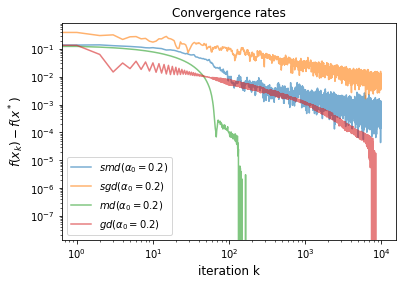

In [18]:
plt.title('Convergence rates', fontsize=12)
transparency = 0.6
plt.loglog(smd_objectives - best_obj, alpha=transparency, label=r'$smd(\alpha_0 = %s)$' % alpha)
plt.loglog(sgd_objectives - best_obj, alpha=transparency, label=r'$sgd(\alpha_0 = %s)$' % alpha)
plt.loglog(md_objectives - best_obj, alpha=transparency, label=r'$md(\alpha_0 = %s)$' % alpha)
plt.loglog(gd_objectives - best_obj, alpha=transparency, label=r'$gd(\alpha_0 = %s)$' % alpha)

plt.xlabel('iteration k', fontsize=12)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize=12)
plt.legend()
plt.show()

## constant learning rate

In [25]:
alpha = 0.001
max_iters = int(1e4)
gd_objectives, gd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=False)
sgd_objectives, sgd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=True)
md_objectives, md_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=False)
smd_objectives, smd_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=True)

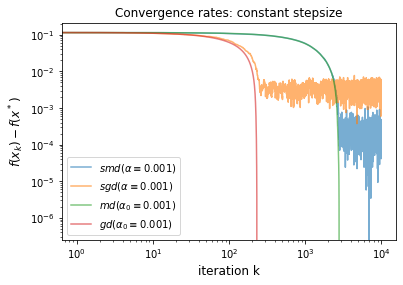

In [26]:
plt.title('Convergence rates: constant stepsize', fontsize=12)

plt.loglog(smd_objectives - best_obj, alpha=transparency, label=r'$smd(\alpha \equiv %s)$' % alpha)
plt.loglog(sgd_objectives - best_obj, alpha=transparency, label=r'$sgd(\alpha \equiv %s)$' % alpha)
plt.loglog(md_objectives - best_obj, alpha=transparency, label=r'$md(\alpha \equiv %s)$' % alpha)
plt.loglog(gd_objectives - best_obj, alpha=transparency, label=r'$gd(\alpha \equiv %s)$' % alpha)

plt.xlabel('iteration k', fontsize=12)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize=12)
plt.legend()
plt.show()

## Only counting gradient evaluations
instead of iterations. Allows the stochastic methods to run $m$ as many iterations.

In [83]:
# less iteration because this time we count gradient evaluations
max_iters = int(5e2)
alpha = 0.2  # this is totally arbitrary, try different learning rates

# Initialization
x_0 = np.ones(A.shape[1])/ A.shape[1]

gd_objectives, gd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
md_objectives, md_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
smd_objectives, smd_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True, count_grad_eval=True)
sgd_objectives, sgd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True, count_grad_eval=True)

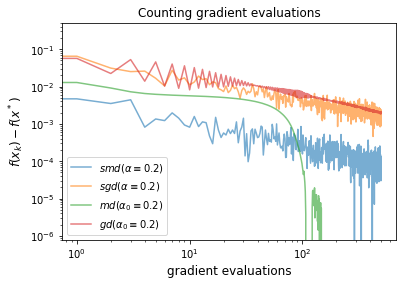

In [84]:
plt.title('Counting gradient evaluations', fontsize=12)

plt.loglog(smd_objectives - best_obj, alpha=transparency, label=r'$smd(\alpha \equiv %s)$' % alpha)
plt.loglog(sgd_objectives - best_obj, alpha=transparency, label=r'$sgd(\alpha \equiv %s)$' % alpha)
plt.loglog(md_objectives - best_obj, alpha=transparency, label=r'$md(\alpha_0 \equiv %s)$' % alpha)
plt.loglog(gd_objectives - best_obj, alpha=transparency, label=r'$gd(\alpha_0 \equiv %s)$' % alpha)

plt.xlabel('gradient evaluations', fontsize=12)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize=12)
plt.legend()
plt.show()

## larger problem size

In [106]:
A, _, xstar = make_regression(n_samples=2000, n_features=300, coef=True)
xstar = np.abs(xstar) / np.linalg.norm(xstar, 1)  # make solution element of unit simplex
noise = t.rvs(df=1, size=A.shape[0])    # one degree of freedom for fat tails
b = A @ xstar + 0.001 * noise
best_obj = objective(A, b, xstar)
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])
print(best_obj)

Number of samples n =  2000
Dimension of each sample d =  300
0.008300244063124903


In [112]:
# Define the parameters of the algorithm.
max_iters = int(1e3)
alpha = 2  # this is totally arbitrary, try different learning rates

# Initialization
x_0 = np.ones(A.shape[1])/ A.shape[1]

gd_objectives, gd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
sgd_objectives, sgd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True)
md_objectives, md_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=False, decr_lr=True)
smd_objectives, smd_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=True, decr_lr=True)

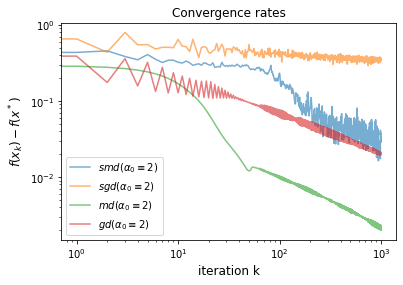

In [113]:
plt.title('Convergence rates', fontsize=12)

plt.loglog(smd_objectives - best_obj, alpha=transparency, label=r'$smd (\alpha_0 \equiv %s)$' % alpha)
plt.loglog(sgd_objectives - best_obj, alpha=transparency, label=r'$sgd (\alpha_0 \equiv %s)$' % alpha)
plt.loglog(md_objectives - best_obj, alpha=transparency, label=r'$md (\alpha_0 \equiv %s)$' % alpha)
plt.loglog(gd_objectives - best_obj, alpha=transparency, label=r'$gd (\alpha_0 \equiv %s)$' % alpha)

plt.xlabel('iteration k', fontsize=12)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize=12)
plt.legend()
plt.show()

## Compare gradient norms across dimension
We claimed in the lecture that even the $2$-norm of a vector might scale like $\sqrt{d}$ even if the infinty norm is bounded. It is easy to see that this occurs for the vector of all ones ($1$). Lets check if we can observe this behaviour also in practice.

In [36]:
for k in [10, 50, 100, 200, 500, 10000, 20000, 50000]:
    A, _, xstar = make_regression(n_samples=500, n_features=k, coef=True)
    xstar = np.abs(xstar) / np.linalg.norm(xstar, 1)  # make solution element of unit simplex
    noise = t.rvs(df=1, size=A.shape[0])    # one degree of freedom for fat tails
    b = A @ xstar + 0.001 * noise
    x_0 = np.ones(A.shape[1])/ A.shape[1]

    print(f'two norm {np.linalg.norm(subgradient(A, b, x_0), 2)} -- \
          infty norm {np.linalg.norm(subgradient(A, b, x_0), ord=np.inf)}' )


two norm 0.8304901637375162
infty norm 0.5253730853535413
two norm 0.8134954125211336
infty norm 0.39607716556628986
two norm 0.9342978839411463
infty norm 0.38957991244909096
two norm 1.0344756943547417
infty norm 0.4092354528937037
two norm 1.235376059659309
infty norm 0.48385278907397394
two norm 4.5184791068695995
infty norm 0.43578729321934473
two norm 6.33683853597438
infty norm 0.38537338890149503
two norm 10.01982564758736
infty norm 0.6242140597309702
